# Model derived from Mobilenet using transfer learning

__Model:__ Example for the Mobilenet feature vector available at [Mobilenet feature vector](https://tfhub.dev/google/tf2-preview/mobilenetv2/featurevector/4)

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


## Get dataset

In [ ]:
# Authenticate to GCS.

from google.colab import auth
auth.authenticate_user()

# Copy data set files
!test -f dataset.zip || gsutil cp gs://onboard_image_dataset/dataset.zip .
!unzip -q -o dataset.zip

Copying gs://onboard_image_dataset/dataset.zip...
\ [1 files][183.3 MiB/183.3 MiB]                                                
Operation completed over 1 objects/183.3 MiB.                                    


## Define train, validation and test sets

In [ ]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
train_dataset = datagen.flow_from_directory(
    'dataset/train',
    target_size=(224,224),
    class_mode='sparse'
)
validation_dataset = datagen.flow_from_directory(
    'dataset/validation',
    target_size=(224,224),
    class_mode='sparse'
)
test_dataset = datagen.flow_from_directory(
    'dataset/test',
    target_size=(224,224),
    class_mode='sparse'
)

Found 630 images belonging to 3 classes.
Found 135 images belonging to 3 classes.
Found 135 images belonging to 3 classes.



## Define CNN using Keras API


In [ ]:
model = tf.keras.Sequential([
        hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", output_shape=[1280],
            trainable=False, input_shape=(224,224,3)),  
            tf.keras.layers.Dense(3, activation='softmax')
        ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


## Train model

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

max_epochs = 50

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
     train_dataset,
     epochs=max_epochs,
     validation_data=validation_dataset,
     callbacks = [stop_early]
)

Epoch 1/50
20/20 [==============================] - 22s 908ms/step - loss: 1.0213 - accuracy: 0.5016 - val_loss: 0.7210 - val_accuracy: 0.7259
Epoch 2/50
20/20 [==============================] - 16s 828ms/step - loss: 0.5824 - accuracy: 0.8270 - val_loss: 0.5253 - val_accuracy: 0.8296
Epoch 3/50
20/20 [==============================] - 16s 825ms/step - loss: 0.4422 - accuracy: 0.8667 - val_loss: 0.4366 - val_accuracy: 0.8444
Epoch 4/50
20/20 [==============================] - 17s 833ms/step - loss: 0.3615 - accuracy: 0.8968 - val_loss: 0.4009 - val_accuracy: 0.8519
Epoch 5/50
20/20 [==============================] - 16s 826ms/step - loss: 0.3155 - accuracy: 0.9032 - val_loss: 0.3793 - val_accuracy: 0.8519
Epoch 6/50
20/20 [==============================] - 17s 832ms/step - loss: 0.2862 - accuracy: 0.9127 - val_loss: 0.3629 - val_accuracy: 0.8593
Epoch 7/50
20/20 [==============================] - 17s 833ms/step - loss: 0.2602 - accuracy: 0.9286 - val_loss: 0.3522 - val_accuracy: 0.8815

## Plot training evolution

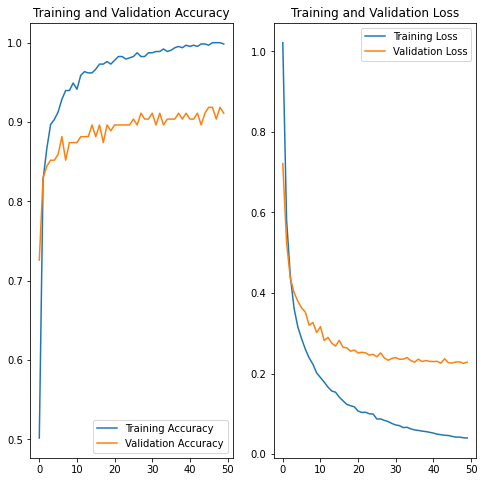

In [ ]:
from  matplotlib import pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Save model and convert it to TFLite format

In [ ]:
model.save('mobilenet')
converter = tf.lite.TFLiteConverter.from_saved_model('mobilenet') # path to the SavedModel directory
tflite_model = converter.convert()
with open('mobilenet.tflite', 'wb') as f:
      f.write(tflite_model)

INFO:tensorflow:Assets written to: mobilenet/assets


INFO:tensorflow:Assets written to: mobilenet/assets


## Calculate accuracy and loss for validation and test datasets

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)

print("VALIDATION - loss {}, accuracy {}".format(loss,accuracy))

loss, accuracy = model.evaluate(test_dataset)

print("TEST - loss {}, accuracy {}".format(loss,accuracy))

5/5 [==============================] - 3s 552ms/step - loss: 0.2282 - accuracy: 0.9111
VALIDATION - loss 0.22824525833129883, accuracy 0.9111111164093018
5/5 [==============================] - 3s 555ms/step - loss: 0.2856 - accuracy: 0.8815
TEST - loss 0.28561288118362427, accuracy 0.8814814686775208
